# COGS 108 - Data Checkpoint

# Names

- Brian Liu
- Audrey Li
- Jessica Mata
- David Ngo
- John Paul Onza

<a id='research_question'></a>
# Research Question

For a given elo in chess, is there an optimal opening that would lead to a higher win percentage?

# Dataset(s)

- Dataset Name: Chess Game Dataset (Lichess)
- Link to the dataset: https://www.kaggle.com/datasets/datasnaek/chess
- Number of observations: Approximately 20,000 observations

This data set are sets of 20,000 games collected from a chess website, Lichess.org. The following dataset contains 16 features such as moveset and the opening ecos
which we need to replace. We are also given the ratings and this will allow us to explore what optimat openings we should use according to ratings.

# Setup

In [195]:
# import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import collections
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

The original dataset wasn't that bad and only needed a little of cleaning. We first removed the columns that we didn't need and the identification to maintain
ethicacy. The biggest problem was the opening_eco and opening variations, because there are multiple types of variation that you can do. We first wanted to 
scrape a website containing the ecos and store it into a dictionary with a standardized format where all variations of an opening will effectively be the same one.
Next we replaced the opening_ecos and removed the opening_name because they contained variations, which we didn't want. We then added a new column for rating difference.


In [2]:
# open data set
games = pd.read_csv('games.csv')

In [3]:
games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [286]:
# check if data is complete

if games.isnull().sum().sum() == 0:
    print('no NaN')
else:
    print('Nan detected')

no NaN


In [287]:
# remove unwanted columns

games_cols = []

for col in games.columns:
    games_cols.append(col)
    
print(games_cols)
print(len(games_cols))
    
wanted_cols = ['winner',
               'white_rating',
               'black_rating',
               'opening_eco'
              ]
# we only want the winners, ratings, and openings
games = games[wanted_cols]

['winner', 'white_rating', 'black_rating', 'opening', 'rating diff']
5


KeyError: "['opening_eco'] not in index"

In [288]:
games.head()

,winner,white_rating,black_rating,opening,rating diff
0,white,1500,1200,Queen's Gambit Declined Slav defence,300
1,black,1300,1300,King's pawn opening,0
2,white,1500,1500,King's pawn game,0
3,white,1400,1500,Queen's pawn game,100
4,white,1500,1500,Philidor's defence,0


In [ ]:
## Scrape openings from https://www.365chess.com/eco.php so we can edit it onto our data set and get desired openings

# get ecos
eco_url = 'https://www.365chess.com/eco.php'
page = requests.get(eco_url)

# parse eco page
soup = BeautifulSoup(page.content, "html.parser")

# scrape ecos
x = soup.find_all(class_ = "opname")


# get raw ecos html
opnames = []
for y in x:
    opnames.append(y.text)
    

# parse raw ecos html into dict
opening_dict = {}

for i in opnames:
    split = i.split()
    if split[0] not in opening_dict:
        opening_dict[split[0]] = ' '.join(split[1:])

# only entry that's messed up, just manually fix it
opening_dict['D50-D69'] = "Queen's Gambit Declined"

In [290]:
## clean dict of ecos and subsets of major openings 

# get range of '-'
def get_range(a):
    num_range = []
    for x in a:
        num_range.append(int(re.sub('\D', '', x)))
    return num_range
        

# create new entries based on major openings and delete old ones
numbers = []
new_dict = opening_dict.copy()

for key in opening_dict:
    if '-' in key:
        numbers = (key.split('-'))
        # num_range = 69
        num_range = get_range(numbers)
        # num_ranges = 10 - 00
        num_ranges = num_range[1] - num_range[0] + 1
        alpha_key = numbers[0][0]
        for x in range(num_ranges):
            num_str = str((num_range[0] + x))
            if len(num_str) < 2:
                num_str = alpha_key + '0' + num_str
            else:
                num_str = alpha_key + num_str
            new_dict[num_str] = opening_dict[key]
        del new_dict[key]
    


op_eco_dict = collections.OrderedDict(sorted(new_dict.items()))

In [291]:
# successfully replace opening_eco
games = games.replace({'opening_eco' : op_eco_dict}) 
games = games.rename(columns = {'opening_eco': 'opening'})


# round games rating
games['white_rating'] = games['white_rating'].round(-2)
games['black_rating'] = games['black_rating'].round(-2)

# get rating diff
games['rating diff'] = abs(games['white_rating'] - games['black_rating'])


# split by winner color now
black_win = games[games['winner'] == 'black'].reset_index(drop = True)
white_win = games[games['winner'] == 'white'].reset_index(drop = True)


In [292]:
games.head()

,winner,white_rating,black_rating,opening,rating diff
0,white,1500,1200,Queen's Gambit Declined Slav defence,300
1,black,1300,1300,King's pawn opening,0
2,white,1500,1500,King's pawn game,0
3,white,1400,1500,Queen's pawn game,100
4,white,1500,1500,Philidor's defence,0


In [293]:
black_win.head()

,winner,white_rating,black_rating,opening,rating diff
0,black,1300,1300,King's pawn opening,0
1,black,1400,2100,King's pawn opening,700
2,black,1400,1400,King's pawn game,0
3,black,1400,1900,French defence,500
4,black,1400,1900,French defence,500


In [294]:
white_win.head()

,winner,white_rating,black_rating,opening,rating diff
0,white,1500,1200,Queen's Gambit Declined Slav defence,300
1,white,1500,1500,King's pawn game,0
2,white,1400,1500,Queen's pawn game,100
3,white,1500,1500,Philidor's defence,0
4,white,1500,1400,Queen's pawn game,100


In [295]:
# get a gist of what our dataset count looks like
print(black_win.shape)
print(white_win.shape)

(9107, 5)
(10001, 5)


<AxesSubplot:xlabel='opening', ylabel='count'>

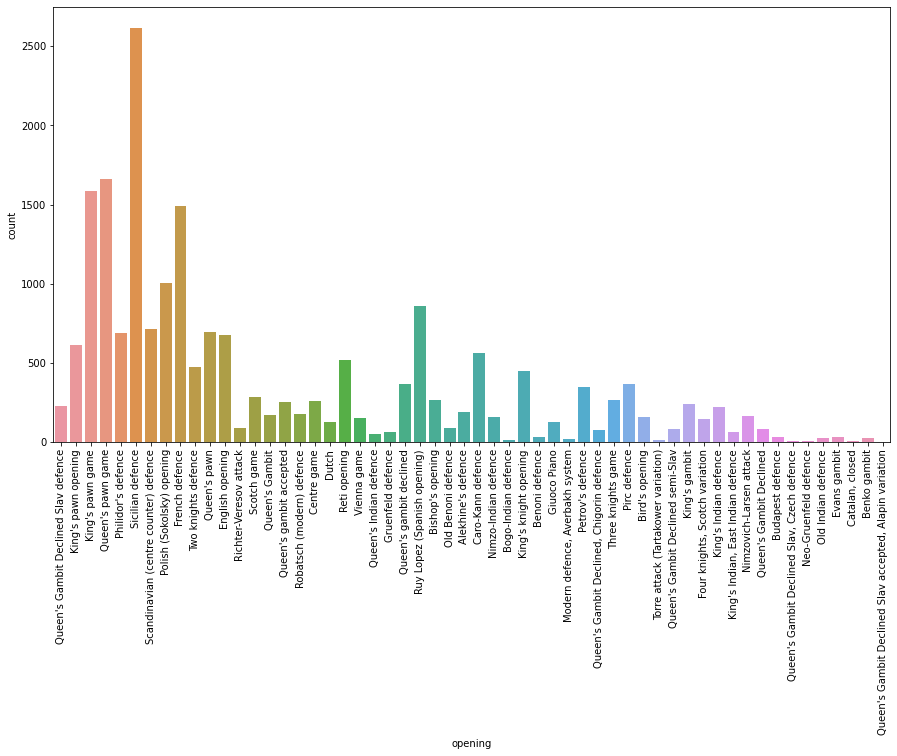

In [296]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
sns.countplot(x = 'opening', data=games)

In [63]:
white_win['opening'].value_counts()

Sicilian defence                                           1197
Queen's pawn game                                           762
French defence                                              737
King's pawn game                                            734
Ruy Lopez (Spanish opening)                                 451
Polish (Sokolsky) opening                                   398
Philidor's defence                                          396
Queen's pawn                                                383
English opening                                             376
King's pawn opening                                         365
Scandinavian (centre counter) defence                       358
Caro-Kann defence                                           276
Reti opening                                                268
King's knight opening                                       266
Two knights defence                                         251
Pirc defence                            

In [68]:
black_win['opening'].value_counts()

Sicilian defence                               1290
Queen's pawn game                               818
King's pawn game                                797
French defence                                  679
Polish (Sokolsky) opening                       570
Ruy Lopez (Spanish opening)                     358
Scandinavian (centre counter) defence           332
Queen's pawn                                    291
English opening                                 272
Philidor's defence                              267
Caro-Kann defence                               251
King's pawn opening                             218
Two knights defence                             201
Reti opening                                    196
King's knight opening                           167
Queen's gambit declined                         155
Pirc defence                                    148
Petrov's defence                                145
Scotch game                                     128
Centre game 

In [66]:
games['opening'].value_counts()

Sicilian defence                                           2617
Queen's pawn game                                          1661
King's pawn game                                           1588
French defence                                             1491
Polish (Sokolsky) opening                                  1007
Ruy Lopez (Spanish opening)                                 858
Scandinavian (centre counter) defence                       716
Queen's pawn                                                693
Philidor's defence                                          691
English opening                                             676
King's pawn opening                                         611
Caro-Kann defence                                           559
Reti opening                                                515
Two knights defence                                         472
King's knight opening                                       446
Pirc defence                            

A question we want to ask first is about to Sicilian defense :
We see that the Sicilian Defense is the most played opening for both sides, which isn't surprising because 
it's one of the more popular lines against the popular e4. pawn. However this is weird, because even though 
the Sicilian is often used, it is a pretty hard line to play, so is it worth playing if you're below a certain elo? To investigate this, let's check the trend of this opening


In [117]:
# get all games that opens with sicilian defence
white_sicilian_games = white_win[white_win['opening'] == 'Sicilian defence']
black_sicilian_games = black_win[black_win['opening'] == 'Sicilian defence']
sicilian_games = games[games['opening'] == 'Sicilian defence']

[Text(0, 0.5, 'Percent')]

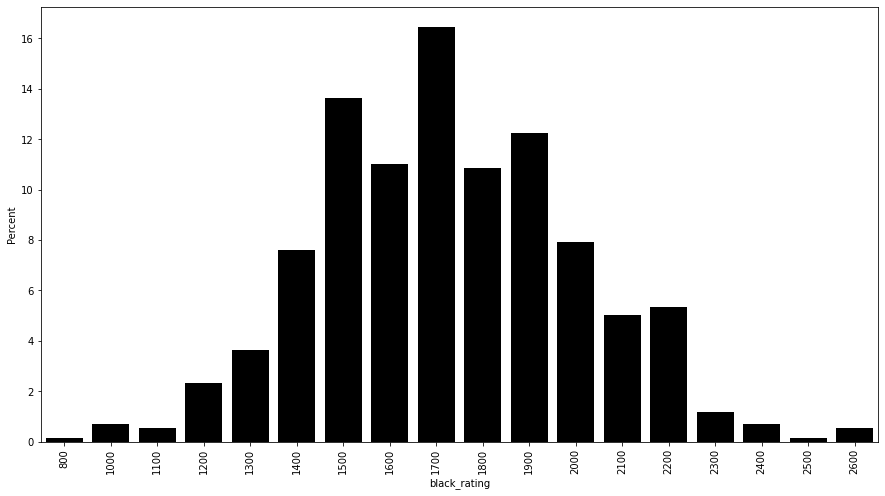

In [134]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
ax = sns.barplot(x="black_rating", y="black_rating", data=black_sicilian_games, estimator=lambda x: len(x) / len(black_sicilian_games) * 100, color = 'black')
ax.set(ylabel="Percent")

[Text(0, 0.5, 'Percent')]

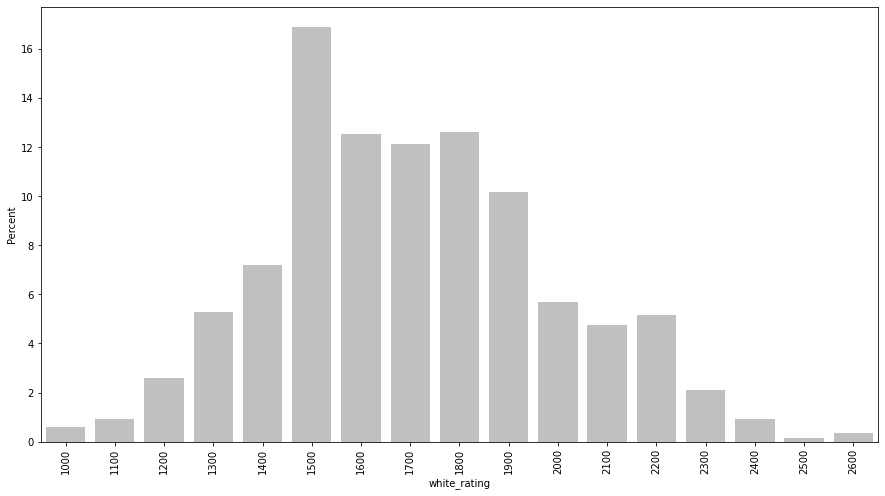

In [136]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
ax = sns.barplot(x="white_rating", y="white_rating", data=white_sicilian_games, estimator=lambda x: len(x) / len(white_sicilian_games) * 100, color = 'silver')
ax.set(ylabel="Percent")

From these two countplots, we can see that there is definitely a trend in the usage of the 'sicilian defense' as the majority of players are within the 1500~1800 range, but it is erroneous to think that is is good to use this opening in that range, because this count plot only shows the usage of this opening, which essentially shows us a bell curve of the elo system, as there is going to be less samples in higher or really lower elo, meaning less games with a particular opened played. Basically we just showed that this is just a popular opening, which we already know from the amount of count data. What we want to see is the win percentage at every elo.

[Text(0, 0.5, 'Percent')]

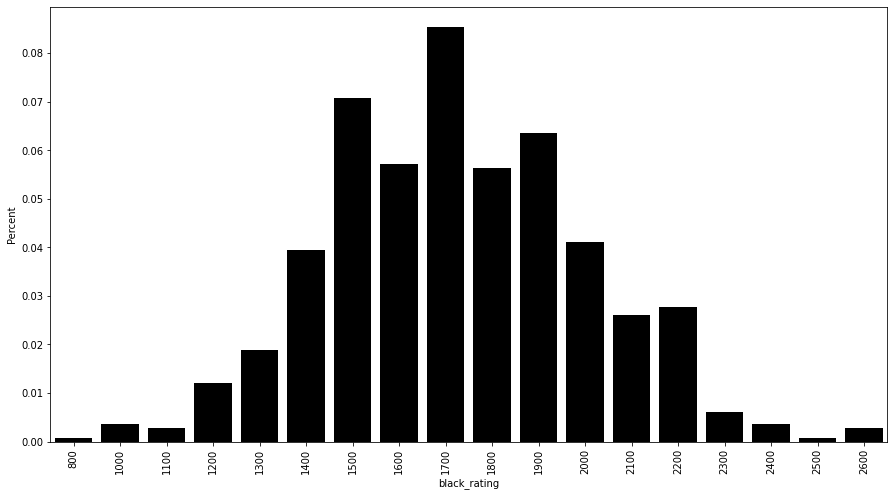

In [145]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="black_rating", y="black_rating", data=black_sicilian_games, estimator=lambda x: len(x), color = 'black')
ax.set(ylabel="Percent")

In [313]:
# get total sicilian games
total = sicilian_games['white_rating'].value_counts() + sicilian_games['black_rating'].value_counts()

white_sicilian_per = white_sicilian_games['white_rating'].value_counts()/ total
black_sicilian_per = black_sicilian_games['black_rating'].value_counts()/ total


white_sicilian_per = white_sicilian_per.dropna()
black_sicilian_per = black_sicilian_per.dropna()

# drop 800 because there white doesn't contain 800
black_sicilian_per = black_sicilian_per.drop(800)

white_sicilian_per

1000    0.104478
1100    0.177419
1200    0.177143
1300    0.226619
1400    0.189427
1500    0.241627
1600    0.243506
1700    0.199725
1800    0.253782
1900    0.233716
2000    0.185286
2100    0.270142
2200    0.326316
2300    0.384615
2400    0.289474
2500    0.285714
2600    0.333333
dtype: float64

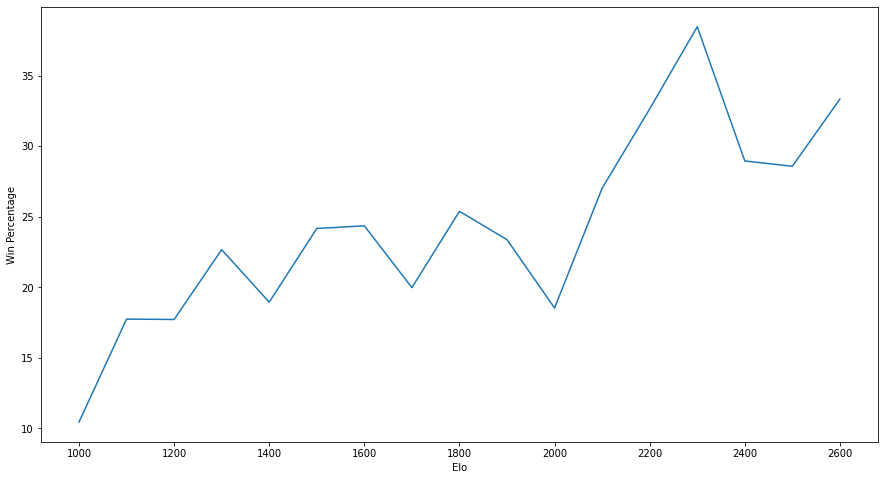

In [281]:
# get win percentage of white using sicilian at every elo
plt.figure(figsize = (15,8))
plt.xlabel("Elo")
plt.ylabel("Win Percentage")
plt.plot(white_sicilian_per.index, white_sicilian_per.values * 100)

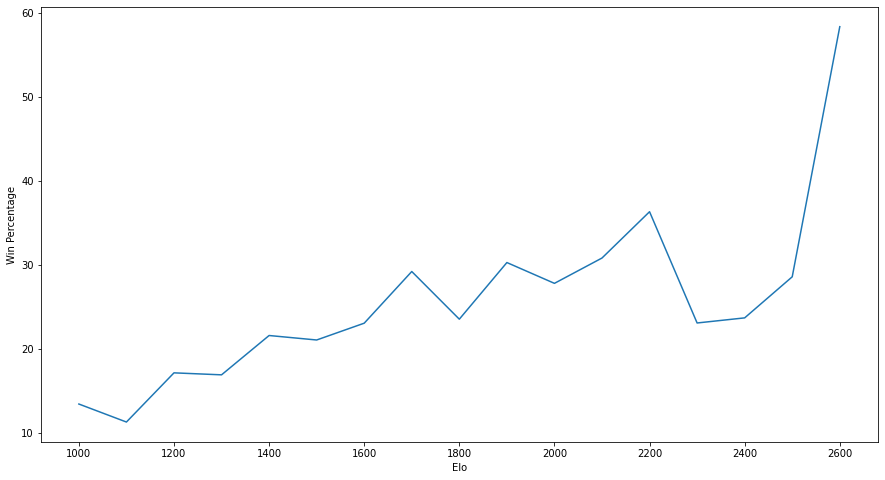

In [284]:
# get win percentage of black using sicilian at every elo
plt.figure(figsize = (15,8))
plt.xlabel("Elo")
plt.ylabel("Win Percentage")
plt.plot(black_sicilian_per.index, black_sicilian_per.values* 100)

From our given analysis, it seems that win rate for the sicilian only increases as your elo increases, which begs the question, does an opening really affect win rate and it also helps answer part of our question, because the sicilian defence is a hard line to play, but how about a very easy opening that beginners are recommended to play like the Spanish Opening or Ruy Lopez


In [297]:
# get all games that opens with sicilian defence
white_ruy_games = white_win[white_win['opening'] == 'Ruy Lopez (Spanish opening)']
black_ruy_games = black_win[black_win['opening'] == 'Ruy Lopez (Spanish opening)']
ruy_games = games[games['opening'] == 'Ruy Lopez (Spanish opening)']

In [299]:
white_ruy_games.head()

,winner,white_rating,black_rating,opening,rating diff
85,white,1900,1800,Ruy Lopez (Spanish opening),100
90,white,1800,1900,Ruy Lopez (Spanish opening),100
95,white,1900,1800,Ruy Lopez (Spanish opening),100
96,white,1800,1800,Ruy Lopez (Spanish opening),0
101,white,1500,1300,Ruy Lopez (Spanish opening),200


In [300]:
black_ruy_games.head()

,winner,white_rating,black_rating,opening,rating diff
48,black,1800,1800,Ruy Lopez (Spanish opening),0
50,black,1900,1800,Ruy Lopez (Spanish opening),100
78,black,1900,1900,Ruy Lopez (Spanish opening),0
93,black,1300,2100,Ruy Lopez (Spanish opening),800
118,black,1600,1500,Ruy Lopez (Spanish opening),100


In [301]:
ruy_games.head()

,winner,white_rating,black_rating,opening,rating diff
114,black,1800,1800,Ruy Lopez (Spanish opening),0
117,black,1900,1800,Ruy Lopez (Spanish opening),100
160,white,1900,1800,Ruy Lopez (Spanish opening),100
166,white,1800,1900,Ruy Lopez (Spanish opening),100
178,black,1900,1900,Ruy Lopez (Spanish opening),0


[Text(0, 0.5, 'Percent')]

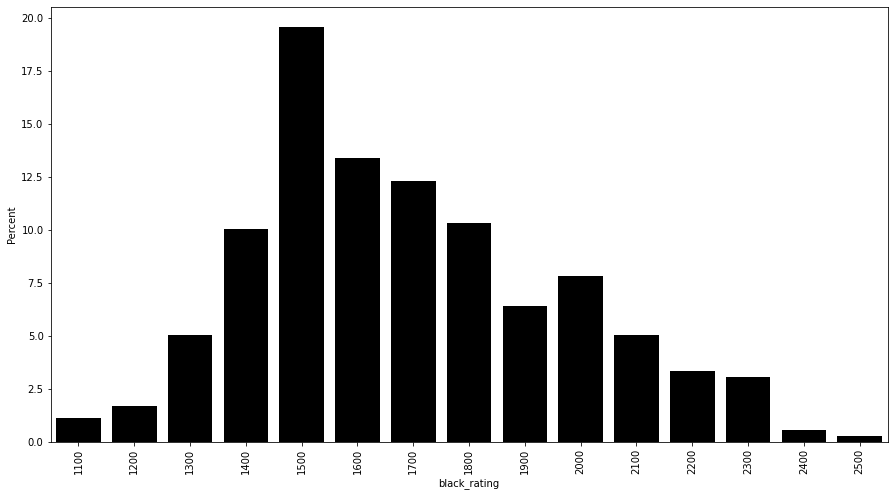

In [303]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
ax = sns.barplot(x="black_rating", y="black_rating", data=black_ruy_games, estimator=lambda x: len(x) / len(black_ruy_games) * 100, color = 'black')
ax.set(ylabel="Percent")

[Text(0, 0.5, 'Percent')]

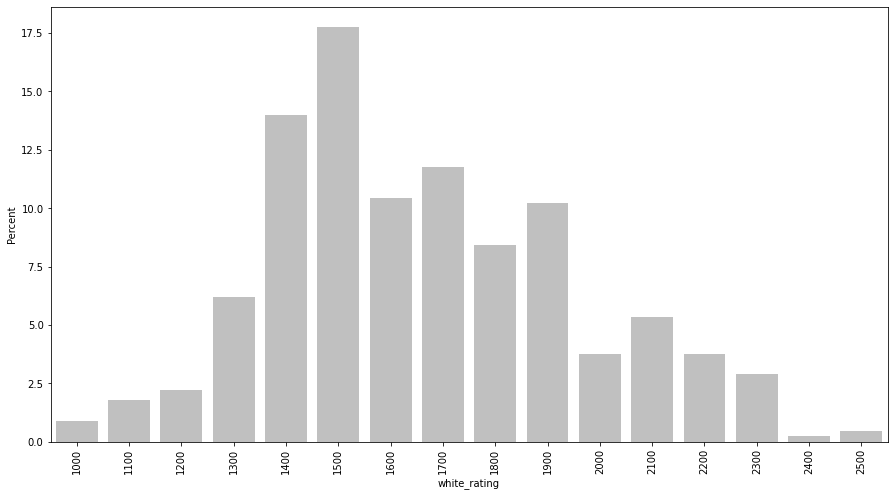

In [304]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
ax = sns.barplot(x="white_rating", y="white_rating", data=white_ruy_games, estimator=lambda x: len(x) / len(white_ruy_games) * 100, color = 'silver')
ax.set(ylabel="Percent")

As we can see, the spanish opening is played more on the left side of the elo chart rather than the right, because it is more simple to play, but how about the win percentage?

In [310]:
# get total ruy games
total_ruy = ruy_games['white_rating'].value_counts() + ruy_games['black_rating'].value_counts()

white_ruy_per = white_ruy_games['white_rating'].value_counts()/ total
black_ruy_per = black_ruy_games['black_rating'].value_counts()/ total


white_ruy_per = white_ruy_per.dropna()
black_ruy_per = black_ruy_per.dropna()

white_ruy_per

1000    0.059701
1100    0.129032
1200    0.057143
1300    0.100719
1400    0.138767
1500    0.095694
1600    0.076299
1700    0.073003
1800    0.063866
1900    0.088123
2000    0.046322
2100    0.113744
2200    0.089474
2300    0.200000
2400    0.026316
2500    0.285714
dtype: float64

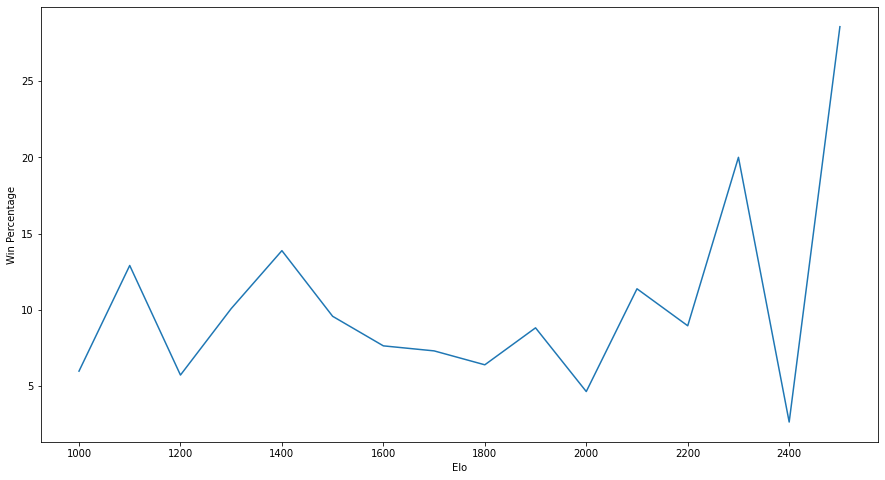

In [315]:
# get win percentage of white using ruy at every elo
plt.figure(figsize = (15,8))
plt.xlabel("Elo")
plt.ylabel("Win Percentage")
plt.plot(white_ruy_per.index, white_ruy_per.values * 100)

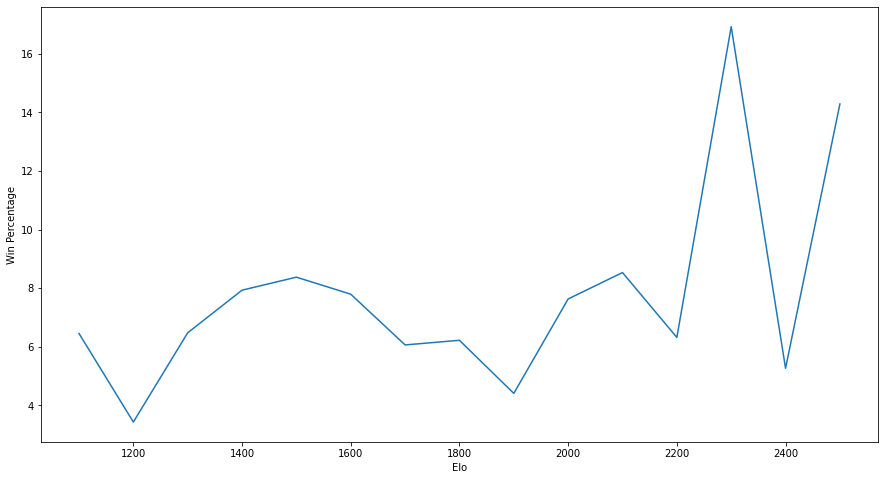

In [316]:
# get win percentage of black using ruy at every elo
plt.figure(figsize = (15,8))
plt.xlabel("Elo")
plt.ylabel("Win Percentage")
plt.plot(black_ruy_per.index, black_ruy_per.values * 100)

Interestingly enough, we don't get that much of a difference between the Ruy Lopez and the Sicilian, even at lower elos where both openings have a similar win rate. What is consistently shown is that as elo increases, so does win percentage which makes sense as your win rate increases as you become a better player.